o# Estimation of COVID-19 pandemic

## Loading data

We will use data on COVID-19 infected individuals, provided by the [Center for Systems Science and Engineering](https://systems.jhu.edu/) (CSSE) at [Johns Hopkins University](https://jhu.edu/). Dataset is available in [this GitHub Repository](https://github.com/CSSEGISandData/COVID-19).

In [2]:
import pytest
import ipytest
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ipytest.autoconfig()
plt.rcParams["figure.figsize"] = (10, 3)  # make figures larger

We can load the most recent data directly from GitHub using `pd.read_csv`. If for some reason the data is not available, you can always use the copy available locally in the `data` folder - just uncomment the line below that defines `base_url`:

In [3]:
# base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"  # loading from Internet
base_url = "../../assets/data/estimation-covid-19/"  # loading from disk
infected_dataset_url = base_url + "time_series_covid19_confirmed_global.csv"
recovered_dataset_url = base_url + "time_series_covid19_recovered_global.csv"
deaths_dataset_url = base_url + "time_series_covid19_deaths_global.csv"
countries_dataset_url = base_url + "UID_ISO_FIPS_LookUp_Table.csv"

Let's now load the data for infected individuals and see how the data looks like:

In [4]:
infected = pd.read_csv(infected_dataset_url)
infected.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209230,209246,209274,209308,209322,209340,209358,209362,209369,209390
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334356,334373,334378,334380,334391,334408,334408,334427,334427,334427
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271436,271439,271440,271440,271441,271448,271463,271469,271469,271477
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47866,47866,47866,47866,47875,47875,47875,47875,47875
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105205,105205,105205,105255,105255,105277,105277,105277,105277,105277


We can see that each row of the table defines the number of infected individuals for each country and/or province, and columns correspond to dates. Similar tables can be loaded for other data, such as number of recovered and number of deaths.

In [5]:
recovered = pd.read_csv(recovered_dataset_url)
deaths = pd.read_csv(deaths_dataset_url)

## Making sense of the data

From the table above the role of province column is not clear. Let's see the different values that are present in `Province/State` column:

In [6]:
infected["Province/State"].value_counts()

Australian Capital Territory    1
Saint Pierre and Miquelon       1
Reunion                         1
New Caledonia                   1
Mayotte                         1
                               ..
Gansu                           1
Fujian                          1
Chongqing                       1
Beijing                         1
Turks and Caicos Islands        1
Name: Province/State, Length: 91, dtype: int64

From the names we can deduce that countries like Australia and China have more detailed breakdown by provinces. Let's look for information on China to see the example:

In [7]:
def filter(df, column_name, column_value):
    if column_name not in df.columns:
        raise Exception("column_name not found in DataFrame")
    if column_value not in df[column_name].values:
        raise ValueError(f"{column_value} not found in column {column_name}")
    return df[df[column_name] == column_value]

filter(infected, "Country/Region", "China")

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23
59,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,2275,2275,2275,2275,2275,2275,2275,2275,2275,2275
60,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,40774,40774,40774,40774,40774,40774,40774,40774,40774,40774
61,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,14715,14715,14715,14715,14715,14715,14715,14715,14715,14715
62,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,17122,17122,17122,17122,17122,17122,17122,17122,17122,17122
63,Gansu,China,35.7518,104.2861,0,2,2,4,7,14,...,1742,1742,1742,1742,1742,1742,1742,1742,1742,1742
64,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,103248,103248,103248,103248,103248,103248,103248,103248,103248,103248
65,Guangxi,China,23.8298,108.7881,2,5,23,23,36,46,...,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371
66,Guizhou,China,26.8154,106.8748,1,3,3,4,5,7,...,2534,2534,2534,2534,2534,2534,2534,2534,2534,2534
67,Hainan,China,19.1959,109.7453,4,5,8,19,22,33,...,10483,10483,10483,10483,10483,10483,10483,10483,10483,10483
68,Hebei,China,39.5490,116.1306,1,1,2,8,13,18,...,3292,3292,3292,3292,3292,3292,3292,3292,3292,3292


In [8]:
%%ipytest -qq

def create_test_df():
    return pd.DataFrame({'numbers': [1, 2, 3, 4, 5], 'bools': [False, False, True, True, True]})

class TestFilter(unittest.TestCase):

    def test_filter_with_happy_case(self):
        # assign
        test_df = create_test_df()
        expected_result = pd.DataFrame({'numbers': [3], 'bools': [True]})
    
        #act
        result = filter(test_df, 'numbers', 3)
    
        #assert
        assert result.reset_index(drop=True).equals(expected_result)
    
    # Test 2 - Filter on non-existing value
    def test_filter_with_invalid_number(self):
        # assign
        test_df = create_test_df()
    
        #act
        with pytest.raises(Exception):
            filter(test_df, 'numbers', 6)

..                                                                                           [100%]


## Pre-processing the data 

We are not interested in breaking countries down to further territories, thus we would first get rid of this breakdown and add information on all territories together, to get info for the whole country. This can be done using `groupby`:

In [9]:
def groupby_sum(df, column_name):
    if df is None:
        raise Exception("df cannot be None.")
    if column_name not in df:
        raise Exception("Column does not exist.")
    return df.groupby(column_name).sum()


infected = groupby_sum(infected, "Country/Region")
recovered = groupby_sum(recovered, "Country/Region")
deaths = groupby_sum(deaths, "Country/Region")

infected.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_16848\23969813.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(column_name).sum()
C:\Users\HP\AppData\Local\Temp\ipykernel_16848\23969813.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(column_name).sum()
C:\Users\HP\AppData\Local\Temp\ipykernel_16848\23969813.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby(column_n

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,...,209230,209246,209274,209308,209322,209340,209358,209362,209369,209390
Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,...,334356,334373,334378,334380,334391,334408,334408,334427,334427,334427
Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,...,271436,271439,271440,271440,271441,271448,271463,271469,271469,271477
Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,...,47866,47866,47866,47866,47866,47875,47875,47875,47875,47875
Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,...,105205,105205,105205,105255,105255,105277,105277,105277,105277,105277


<h5><font color=blue>Check result by executing below... 📝</font></h5>

In [10]:
%%ipytest -qq

def create_test_df():
    return pd.DataFrame(
        {
            'c1': [1, 1, 1, 2, 2], 
            'c2': [6, 7, 8, 9, 10]
        }
    )

class TestGroupbySum(unittest.TestCase):

    def test_groupby_sum_happy_case(self):
        # assign
        test_df = create_test_df()

        # act
        actual_result = groupby_sum(test_df, 'c1')
    

        # assert
        assert actual_result.iloc[0, 0] == 21
        assert actual_result.iloc[1, 0] == 19

    def test_groupby_sum_with_none_df(self):
        #act
        with pytest.raises(Exception):
            groupby_sum(None, 'c1')
        
    def test_groupby_sum_with_invalid_column_name(self):
        #assign
        test_df = create_test_df()
    
        #act
        with pytest.raises(Exception):
            groupby_sum(test_df, 'c100')

...                                                                                          [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>pandas.DataFrame.groupby()</code> and <code>aggregation function sum()</code>.

</details>

</div>

You can see that due to using `groupby` all DataFrames are now indexed by Country/Region. We can thus access the data for a specific country by using `.loc`:|

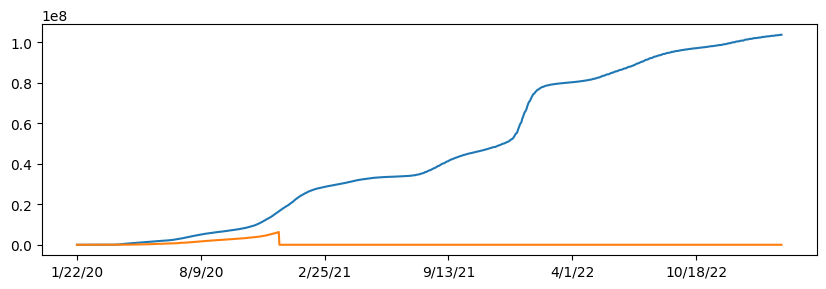

In [11]:
def plot_infected_vs_recovered(column_name):
    infected.loc[column_name][2:].plot()
    recovered.loc[column_name][2:].plot()
    plt.show()


plot_infected_vs_recovered("US")

> **Note** how we use `[2:]` to remove first two elements of a sequence that contain geolocation of a country. We can also drop those two columns altogether:

In [12]:
def drop_columns(df, columns):
    if df is None:
        raise Exception("df cannot be None.")

    return df.drop(columns=columns, inplace=True)

drop_columns(infected, ["Lat", "Long"])
drop_columns(recovered, ["Lat", "Long"])
drop_columns(deaths, ["Lat", "Long"])

<h5><font color=blue>Check result by executing below... 📝</font></h5>

In [13]:
%%ipytest -qq

def create_test_df():
    return pd.DataFrame(
        {
            "c1": [1, 2, 3, 4, 5],
            "c2": [6, 7, 8, 9, 10],
            "c3": [11, 12, 13, 14, 15],
            "c4": [16, 17, 18, 19, 20],
        }
    )


class TestDropColumns(unittest.TestCase):
    def test_drop_columns_with_empty_df(self):
        # act
        with pytest.raises(Exception):
            get_drop_columns(pd.DataFrame(), "c1")
    
    def test_drop_columns_happy_case(self):
        # assign
        test_df = create_test_df()
        test_dropped_df=pd.DataFrame(
            {
                "c3": [11, 12, 13, 14, 15],
                "c4": [16, 17, 18, 19, 20],
            }
        )
        # act
        drop_columns(test_df, ["c1", "c2"])

        # assert
        from pandas.testing import assert_frame_equal
        assert_frame_equal(test_df,test_dropped_df)

    def test_drop_columns_with_none_df(self):
        # act
        with pytest.raises(Exception):
            get_drop_columns(None, "c1")

...                                                                                          [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>drop</code>.

</details>

</div>

## Investigating the data

Let's now switch to investigating a specific country. Let's create a frame that contains the data on infections indexed by date:

In [14]:
def mkframe(infected_df, recovered_df, deaths_df, index_name):
    if infected_df is None:
        raise Exception("infected_df cannot be None.")
    if recovered_df is None:
        raise Exception("recovered_df cannot be None.")
    if deaths_df is None:
        raise Exception("deaths_df cannot be None.")
    if index_name not in infected_df.index:
        raise Exception("Index does not exist in infected_df.index.")
    if index_name not in recovered_df.index:
        raise Exception("Index does not exist in recovered_df.index.")
    if index_name not in deaths_df.index:
        raise Exception("Index does not exist in deaths_df.index.")
    df = pd.DataFrame(
        {
            "infected": infected_df.loc[index_name],
            "recovered": recovered_df.loc[index_name],
            "deaths": deaths_df.loc[index_name],
        }
    )
    df.index = pd.to_datetime(df.index)
    return df

df = mkframe(infected, recovered, deaths, "US")

<h5><font color=blue>Check result by executing below... 📝</font></h5>

In [15]:
%%ipytest -qq

def create_test_df_1():

    return pd.DataFrame(
        data=[[2, 5, 9], [3, 4, 10], [9, 9, 8]],
        columns=["1/22/20", "1/23/20", "1/24/20"],
        index=["US", "UK", "FR"],
    )

def create_test_df_2():
    return pd.DataFrame(
        data=[[9, 9, 8], [2, 5, 9], [3, 4, 10]],
        columns=["1/22/20", "1/23/20", "1/24/20"],
        index=["US", "UK", "FR"],
    )

def create_test_df_3():
    return pd.DataFrame(
        data=[[3, 4, 10], [9, 9, 8], [2, 5, 9]],
        columns=["1/22/20", "1/23/20", "1/24/20"],
        index=["US", "UK", "FR"],
    )

class TestDropColumns(unittest.TestCase):
    def test_mkframe_happy_case(self):
        # assign
        test_df_1 = create_test_df_1()
        test_df_2 = create_test_df_2()
        test_df_3 = create_test_df_3()
        expected_mkframe_df = pd.DataFrame(
            data = [[2, 9, 3],[5, 9, 4],[9, 8, 10]],
            columns =["infected","recovered","deaths"],
            index =["2020-01-22","2020-01-23","2020-01-24"]
        )
        expected_mkframe_df.index = pd.to_datetime(expected_mkframe_df.index)


        # act
        test_df = mkframe(test_df_1, test_df_2, test_df_3, "US")

        # assert
        from pandas.testing import assert_frame_equal
        assert_frame_equal(test_df,expected_mkframe_df)

    def test_mkframe_with_none_df_1(self):
        # act
        with pytest.raises(Exception):
            get_drop_columns(None, test_df_2, test_df_3, "US")

    def test_mkframe_with_none_df_2(self):
        # act
        with pytest.raises(Exception):
            get_drop_columns(test_df_1, None, test_df_3, "US")

    def test_mkframe_with_none_df_3(self):
        # act
        with pytest.raises(Exception):
            get_drop_columns(test_df_1, test_df_2, None, "US")

    def test_mkframe_with_invalid_column_name(self):
        # assign
        test_df_1 = create_test_df_1()
        test_df_2 = create_test_df_2()
        test_df_3 = create_test_df_3()

        # act
        with pytest.raises(Exception):
            get_onecolumn_groupby_sum(test_df_1, test_df_2, test_df_3, "China")

.....                                                                                        [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>pandas.to_datetime</code>.

</details>

</div>

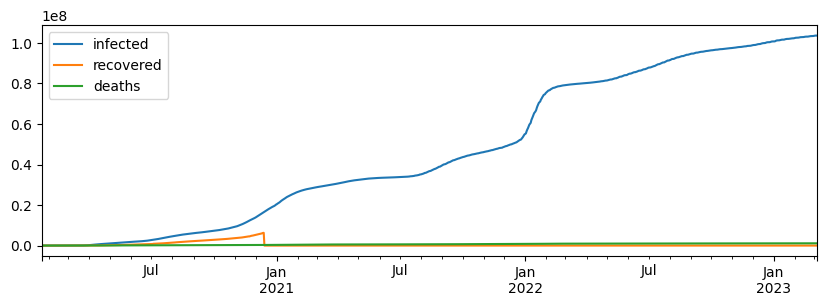

In [16]:
df.plot()
plt.show()

Now let's compute the number of new infected people each day. This will allow us to see the speed at which pandemic progresses. The easiest day to do it is to use `diff`:

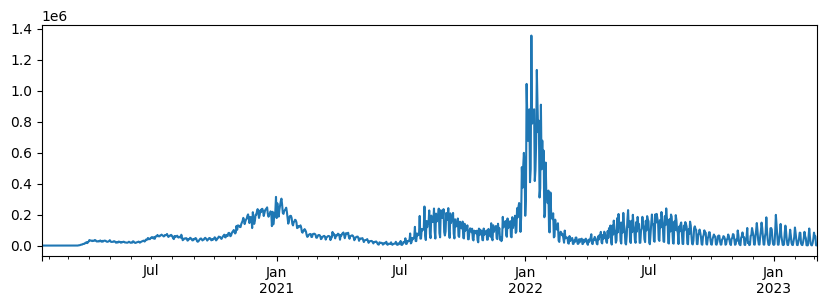

In [22]:
def column_to_show_by_getting_column_to_diff(
    df, column_name_to_show, column_name_to_diff
):
    if df is None:
        raise Exception("df cannot be None")
    if column_name_to_diff not in df.columns:
        raise Exception("column_name_to_diff not exist in df")

    df[column_name_to_show] = df[column_name_to_diff].diff()
    return df[column_name_to_show]

column_to_show_by_getting_column_to_diff(df, "ninfected", "infected").plot()
plt.show()

In [24]:
%%ipytest -qq

def create_test_df():
    return  pd.DataFrame({
            'date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06'],
            'column1': [1, 2, 4, 6, 9, 13],
            'column2': [1, 3, 6, 10, 15, 21]
        })


class TestDropColumns(unittest.TestCase):
    def test_column_to_show_by_getting_column_to_diff(self):
        # assign
        df = create_test_df()
        expected_result = pd.Series([np.nan, 1.0, 2.0, 2.0, 3.0, 4.0], name='diff_column')
        
        # act
        actual_result = column_to_show_by_getting_column_to_diff(df, 'diff_column', 'column1')

        # assert
        from pandas.testing import assert_series_equal
        assert_series_equal(actual_result, expected_result)

    def test_column_to_show_by_getting_column_to_diff_with_none_df(self):
        # act
        with pytest.raises(Exception):
            column_to_show_by_getting_column_to_diff(None, "column_name_to_show", "column1")

    def test_column_to_show_by_getting_column_to_diff_with_none_column_name_to_diff(self):
        #assign
        df = create_test_df()
        
        # act
        with pytest.raises(Exception):
            column_to_show_by_getting_column_to_diff(df,"column_name_to_show","column_name_to_diff")


...                                                                                          [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>diff()</code>.

</details>

</div>

We can see high fluctuations in data. Let's look closer at one of the months:

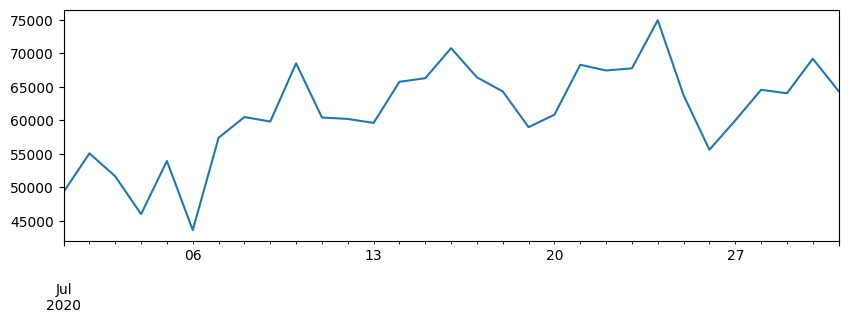

In [26]:
def filter_ninfected_by_year_and_month(df, year, month):
    return df[(df.index.year == year) & (df.index.month == month)]["ninfected"]


filter_ninfected_by_year_and_month(df, 2020, 7).plot()
plt.show()

In [27]:
%%ipytest -qq

def create_test_df():
    test_df = pd.DataFrame(
        data=[[2, 9, 3, None], [5, 9, 4, 3], [9, 8, 10, 4]],
        columns=["infected", "recovered", "deaths", "ninfected"],
        index=["2020-01-22", "2020-01-23", "2020-01-24"],
    )
    test_df.index = pd.to_datetime(test_df.index)
    return test_df


class TestFilter_ninfected_by_year_and_month(unittest.TestCase):
    def test_filter_ninfected_by_year_and_month_happy_case(self):
        # assign
        test_df = create_test_df()
        expected_result = pd.Series(
            [None, 3, 4],
            index=pd.to_datetime(["2020-01-22", "2020-01-23", "2020-01-24"]),
            name="ninfected",
        )

        # act
        result = filter_ninfected_by_year_and_month(test_df, 2020, 1)

        # assert
        assert result.equals(expected_result)

.                                                                                            [100%]


It clearly looks like there are weekly fluctuations in data. Because we want to be able to see the trends, it makes sense to smooth out the curve by computing running average (i.e. for each day we will compute the average value of the previous several days):

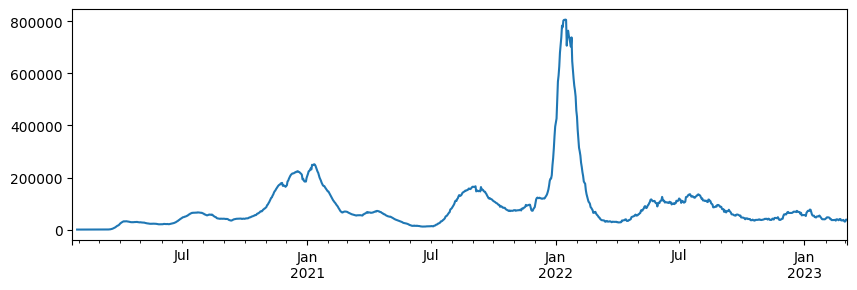

In [28]:
def get_rolling_window(df, column, window):
    return df[column].rolling(window)


df["ninfav"] = get_rolling_window(df, "ninfected", 7).mean()
df["ninfav"].plot()
plt.show()

In order to be able to compare several countries, we might want to take the country's population into account, and compare the percentage of infected individuals with respect to country's population. In order to get country's population, let's load the dataset of countries:

In [29]:
countries = pd.read_csv(countries_dataset_url)
countries

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.939110,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.153300,20.168300,Albania,2877800.0
2,10,AQ,ATA,10.0,NaN,NaN,NaN,Antarctica,-71.949900,23.347000,Antarctica,NaN
3,12,DZ,DZA,12.0,NaN,NaN,NaN,Algeria,28.033900,1.659600,Algeria,43851043.0
4,20,AD,AND,20.0,NaN,NaN,NaN,Andorra,42.506300,1.521800,Andorra,77265.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4316,84056037,US,USA,840.0,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",42343.0
4317,84056039,US,USA,840.0,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",23464.0
4318,84056041,US,USA,840.0,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",20226.0
4319,84056043,US,USA,840.0,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",7805.0


Because this dataset contains information on both countries and provinces, to get the population of the whole country we need to be a little bit clever: 

In [30]:
def filter_by_country_region(df, countries_and_region):
    if countries_and_region not in df["Country_Region"].unique():
        raise Exception("countries_and_region name is wrong.")
    return df[
        (df["Country_Region"] == countries_and_region) & df["Province_State"].isna()
    ]

filter_by_country_region(countries, "US")

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
915,840,US,USA,840.0,NaN,NaN,NaN,US,40.0,-100.0,US,329466283.0


In [31]:
%%ipytest -qq
from pandas.testing import assert_frame_equal
def create_test_df():
        return pd.DataFrame({
            "Country_Region": ["US", "US", "UK", "FR", "JP"],
            "Province_State": [None, "California", None, None, "Tokyo"],
            "Confirmed": [100, 50, 70, 80, 90],
            "Deaths": [10, 5, 7, 8, 9],
            "Recovered": [20, 10, 14, 16, 18]
        })
        
class TestFilterByCountryRegion(unittest.TestCase):
    
    def test_filter_by_country_region(self):
        # assign
        
        test_df=create_test_df()
        expected_result = pd.DataFrame({
            "Country_Region": ["US"],
            "Province_State": [None],
            "Confirmed": [100],
            "Deaths": [10],
            "Recovered": [20]
        })
    
        # act
        actual_result = filter_by_country_region(test_df, "US")
    
        # assert
        assert_frame_equal(expected_result, actual_result)

    def test_filter_by_country_region_with_nonexistent_country(self):
        
        test_df=create_test_df()
        with pytest.raises(Exception):
            filter_by_country_region(test_df, "China")

    def test_filter_by_country_region_with_province_state_data(self):
        # arrange
        test_df=create_test_df()
        expected_output = pd.DataFrame({
            "Country_Region": ["FR"],
            "Province_State": [None],
            "Confirmed": [80],
            "Deaths": [8],
            "Recovered": [16]
        }, index=pd.Index([3], dtype='int64'))

        # act
        actual_output = filter_by_country_region(test_df, "FR")

        # assert
        assert_frame_equal(expected_output, actual_output)
        
    def test_filter_by_country_region_without_None_Province_State(self):
        #arrange
        test_df=create_test_df()
        
        #act
        result = filter_by_country_region(test_df, "JP")
        
        #assert
        assert result.empty

....                                                                                         [100%]


2020-01-22    3.035212e-07
2020-01-23    3.035212e-07
2020-01-24    6.070424e-07
2020-01-25    6.070424e-07
2020-01-26    1.517606e-06
                  ...     
2023-03-01    3.142127e+01
2023-03-02    3.143983e+01
2023-03-03    3.145807e+01
2023-03-04    3.145866e+01
2023-03-05    3.145904e+01
Name: pinfected, Length: 1139, dtype: float64


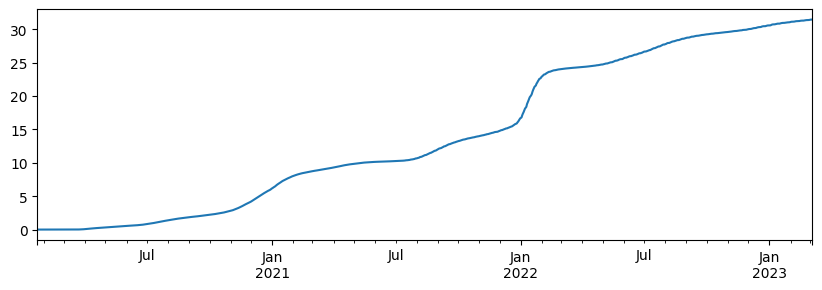

In [45]:
def get_pinfected(df):
    if df is None:
        raise Exception("df cannot be none")
    pop = filter_by_country_region(countries, "US")["Population"].iloc[0]
    return df["infected"] * 100 / pop

df["pinfected"] = get_pinfected(df)
print(df["pinfected"])
df["pinfected"].plot(figsize=(10, 3))
plt.show()

In [47]:
%%ipytest -qq
from pandas.testing import assert_frame_equal

def create_test_df():
        return pd.DataFrame({
            "Country_Region": ["US", "US", "Canada", "Canada"],
            "Province_State": ["California", "New York", "Ontario", "Quebec"],
            "Population": [10000, 20000, 30000, 40000],
            "infected": [1000, 2000, 3000, 4000]
        })
        
class TestGetPinfected(unittest.TestCase):
    
    def test_get_pinfected_with_happy_case(self):
        #assign
        test_df = create_test_df()
        expected_result = pd.Series([0.00030352119521741776, 0.0006070423904348355, 0.0009105635856522532, 0.001214084780869671],name="infected")
        
        #act
        actual_result = get_pinfected(test_df)
        
        #assert
        from pandas.testing import assert_series_equal
        assert_series_equal(expected_result, actual_result, rtol=1e-3)
    
    def test_get_pinfected_with_none_df(self):
        
        #act
        with pytest.raises(Exception):
            get_pinfected(None)

    def test_get_pinfected_with_empty_df(self):

        # act
        with pytest.raises(Exception):
            get_pinfected(pd.DataFrame())

...                                                                                          [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>&</code>

</details>

</div>


## Computing $R_t$

To see how infectious is the disease, we look at the **basic reproduction number** $R_0$, which indicated the number of people that an infected person would further infect. When $R_0$ is more than 1, the epidemic is likely to spread.

$R_0$ is a property of the disease itself, and does not take into account some protective measures that people may take to slow down the pandemic. During the pandemic progression, we can estimate the reproduction number $R_t$ at any given time $t$. It has been shown that this number can be roughly estimated by taking a window of 8 days, and computing $$R_t=\frac{I_{t-7}+I_{t-6}+I_{t-5}+I_{t-4}}{I_{t-3}+I_{t-2}+I_{t-1}+I_t}$$
where $I_t$ is the number of newly infected individuals on day $t$.

Let's compute $R_t$ for our pandemic data. To do this, we will take a rolling window of 8 `ninfected` values, and apply the function to compute the ratio above:

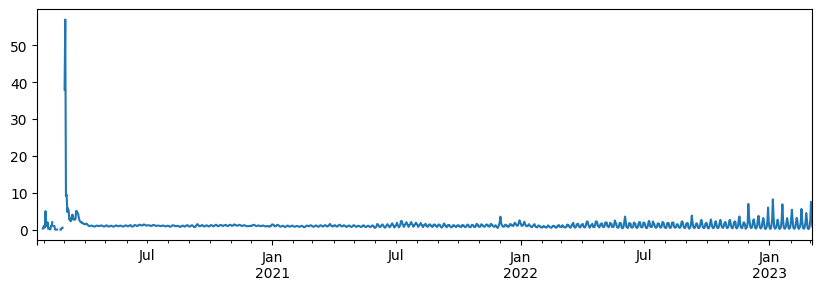

In [50]:
def get_rt(df, column_name, window):
    df["Rt"] = get_rolling_window(df, column_name, window).apply(
        lambda x: x[4:].sum() / x[:4].sum()
    )
    return df["Rt"]

get_rt(df, "ninfected", 8)
df["Rt"].plot()
plt.show()

In [54]:
%%ipytest -qq
from pandas.testing import assert_series_equal
def create_test_df():
        return pd.DataFrame(
            {
                "date": pd.date_range("2022-01-01", periods=18),
                "infected": [10, 15, 20, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 110, 120, 130, 140],
            }
        )

class TestGetRt(unittest.TestCase):
    def test_get_rt(self):
        # assign
        test_df = create_test_df()
        expected_output = pd.Series([None, None, None, None, None, None, None, 2.2666666666666666, 1.9, 1.68, 1.5666666666666667, 1.5588235294117647, 1.5789473684210527, 1.619047619047619, 1.6170212765957446, 1.5849056603773586, 1.5333333333333334, 1.4705882352941178], dtype=np.float64)

        # act
        result = get_rt(test_df, "infected", 8)

        # assert
        assert_series_equal(result, expected_output, rtol=0.001, check_dtype=False, check_names=False)

.                                                                                            [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>lambda</code>

</details>

</div>

You can see that there are some gaps in the graph. Those can be caused by either `NaN`, if  `inf` values being present in the dataset. `inf` may be caused by division by 0, and `NaN` can indicate missing data, or no data available to compute the result (like in the very beginning of our frame, where rolling window of width 8 is not yet available). To make the graph nicer, we need to fill those values using `replace` and `fillna` function.

Let's further look at the beginning of the pandemic. We will also limit the y-axis values to show only values below 6, in order to see better, and draw horizontal line at 1.

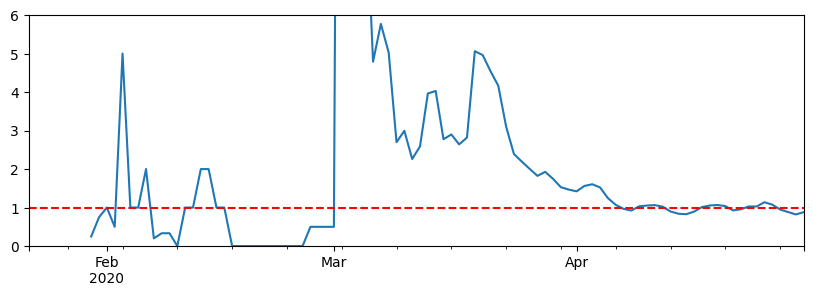

In [55]:
def rt_with_na_filled(df):
    return (
        df[df.index < "2020-05-01"]["Rt"].replace(np.inf, np.nan).replace(method="pad")
    )


ax = rt_with_na_filled(df).plot(figsize=(10, 3))
ax.set_ylim([0, 6])
ax.axhline(1, linestyle="--", color="red")
plt.show()


In [56]:
%%ipytest -qq

def create_test_df():
    return pd.DataFrame(
        {"Rt": [1.5, np.inf, 1.2, np.inf]},
        index=pd.to_datetime(["2020-04-29", "2020-04-30", "2020-05-01", "2020-05-02"]),
    )

class TestFilterByCountryRegion(unittest.TestCase):
    
    def test_filter_by_country_region_population(self):
        # assign
        test_df = create_test_df()
        expected_result = pd.Series(
    [1.5, 1.5], index=pd.to_datetime(["2020-04-29", "2020-04-30"]), name="Rt"
)
        #act
        result = rt_with_na_filled(test_df)

        #assert
        pd.testing.assert_series_equal(result, expected_result)

.                                                                                            [100%]


Another interesting indicator of the pandemic is the **derivative**, or **daily difference** in new cases. It allows us to see clearly when pandemic is increasing or declining. 

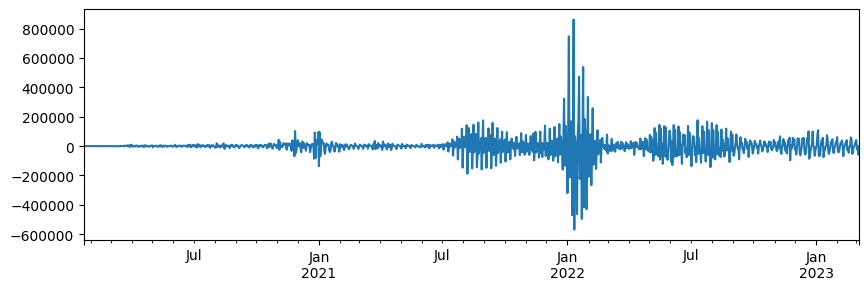

In [57]:
def get_df_column_diff(df, column_name):
    if df is None:
        raise Exception("df cannot be None")
    if column_name not in df.columns:
        raise Exception("column not exist")
    return df[column_name].diff()

diff_series = get_df_column_diff(df, "ninfected")
diff_series.plot()
plt.show()

In [64]:
%%ipytest -qq
from pandas.testing import assert_series_equal
def create_test_df():
        test_df = pd.DataFrame(
            {
                "date": [
                    "2022-01-01",
                    "2022-01-02",
                    "2022-01-03",
                    "2022-01-04",
                    "2022-01-05",
                    "2022-01-06",
                ],
                "ninfected": [100, 110, 120, 130, 140, 150],
            }
        )
        test_df["date"] = pd.to_datetime(test_df["date"])
        test_df.set_index("date", inplace=True)
        return test_df

class TestGetDfColumnDiff(unittest.TestCase):
    def test_get_df_column_diff_with_happy_cases(Self):
        #assign
        test_df = create_test_df()
        expected_diff = pd.Series(
            [None, 10, 10, 10, 10, 10],
            index=pd.to_datetime(
                [
                    "2022-01-01",
                    "2022-01-02",
                    "2022-01-03",
                    "2022-01-04",
                    "2022-01-05",
                    "2022-01-06",
                ]
            ),
        )
        
        #act
        column_diff = get_df_column_diff(test_df, "ninfected")
        
        #assert
        assert_series_equal(column_diff, expected_diff, check_dtype=False, check_names=False)
    
    def test_get_df_column_diff_with_none_df(Self):
        #act
        with pytest.raises(Exception):
            get_df_column_diff(None,"ninfected")
        
    def test_get_df_column_diff_with_invalid_column_name(Self):
        #assign
        test_df=create_test_df()
        
        #act
        with pytest.raises(Exception):
            get_df_column_diff(test_df,"invalid_column_name")

...                                                                                          [100%]


<div class="alert alert-info">
    
<details><summary>👩‍💻 <b>Hint</b></summary>

You can consider to use <code>pandas.DataFrame.diff()</code> 

</details>

</div>

Given the fact that there are a lot of fluctuations in data caused by reporting, it makes sense to smooth the curve by running rolling average to get the overall picture. Let's again focus on the first months of the pandemic:

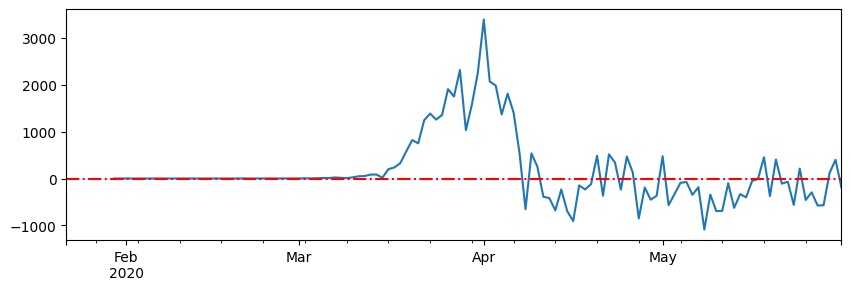

In [63]:
def get_smoothed_ax(df, column_name, datetime, window):
    df_filtered = df[df.index < datetime]
    df_diff = df_filtered[column_name].diff()
    df_rolling_mean = df_diff.rolling(window).mean()

    return df_rolling_mean

df_rolling_mean = get_smoothed_ax(df, "ninfected", "2020-06-01", 7)
ax = df_rolling_mean.plot()
ax.axhline(0, linestyle="-.", color="red")
plt.show()

In [66]:
%%ipytest -qq
from pandas.testing import assert_series_equal
def create_test_df():
        test_df = pd.DataFrame(
            {
                "date": [
                    "2022-01-01",
                    "2022-01-02",
                    "2022-01-03",
                    "2022-01-04",
                    "2022-01-05",
                    "2022-01-06",
                ],
                "ninfected": [100, 110, 120, 130, 140, 150],
            }
        )
        test_df["date"] = pd.to_datetime(test_df["date"])
        test_df.set_index("date", inplace=True)
        return test_df
    
class TestGetSmoothedAx(unittest.TestCase):

    def test_get_smoothed_ax_with_happy_cases(Self):
        # assign        
        test_df = create_test_df()
        expected_result = pd.Series(
            [np.nan, np.nan, np.nan, 10.0, 10.0, 10],
            index=pd.to_datetime(
                [
                    "2022-01-01",
                    "2022-01-02",
                    "2022-01-03",
                    "2022-01-04",
                    "2022-01-05",
                    "2022-01-06",
                ]
            ),
        )
        
        #act
        result = get_smoothed_ax(test_df, "ninfected", "2022-01-07", 3)
        
        #assert
        assert_series_equal(result, expected_result, check_dtype=False, check_names=False)

.                                                                                            [100%]



## Challenge

Now it is time for you to play more with the code and data! Here are a few suggestions you can experiment with:
* See the spread of the pandemic in different countries.
* Plot $R_t$ graphs for several countries on one plot for comparison, or make several plots side-by-side
* See how the number of deaths and recoveries correlate with number of infected cases.
* Try to find out how long a typical disease lasts by visually correlating infection rate and deaths rate and looking for some anomalies. You may need to look at different countries to find that out.
* Calculate the fatality rate and how it changes over time. You may want to take into account the length of the disease in days to shift one time series before doing calculations

## References

You may look at further studies of COVID epidemic spread in the following publications:
* [Sliding SIR Model for Rt Estimation during COVID Pandemic](https://soshnikov.com/science/sliding-sir-model-for-rt-estimation/), blog post by [Dmitry Soshnikov](http://soshnikov.com)
* T.Petrova, D.Soshnikov, A.Grunin. [Estimation of Time-Dependent Reproduction Number for Global COVID-19 Outbreak](https://www.preprints.org/manuscript/202006.0289/v1). *Preprints* **2020**, 2020060289 (doi: 10.20944/preprints202006.0289.v1)
* [Code for the above paper on GitHub](https://github.com/shwars/SlidingSIR)

## Acknowledgments

Thanks to Microsoft for creating the open-source course [Data Science for Beginners](https://github.com/microsoft/Data-Science-For-Beginners). It inspires the majority of the content in this chapter.
